In [1]:
#Import all the necessary modules
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
%matplotlib inline

In [2]:
df = pd.read_excel('Credit Card Customer Data.xlsx')
#Meaning of columns are as said on the column names

## 1) EDA 

In [3]:
#null check
def null_check(data):
        dtype = data.dtypes
        null = data.isnull().sum()
        unique = data.nunique()
        
        data_conc = pd.concat([dtype,null,unique], axis=1)
        data_conc.columns = ['dtype','null','unique']
        data_conc['%Null'] = data_conc['null'].values/len(data)
        
        return data_conc
null_check(df)
#No Null values observed and are all integers
#Repeating Customer Key due to having more than one creditcard

,dtype,null,unique,%Null
Sl_No,int64,0,660,0.0
Customer Key,int64,0,655,0.0
Avg_Credit_Limit,int64,0,110,0.0
Total_Credit_Cards,int64,0,10,0.0
Total_visits_bank,int64,0,6,0.0
Total_visits_online,int64,0,16,0.0
Total_calls_made,int64,0,11,0.0


In [4]:
#Check Skewness and other statistical details on Continuous Variable to check for outlier spread.
df_stat = pd.concat([df.describe().T,df.skew()],axis=1).rename(columns = {0:'Skewness'})
df_stat['Range']=df_stat['max']-df_stat['min']
df_stat
#There are NO negative numbers
#Skewness is highest for Avg_Credit_Limit and Total_visits_online hence needing to normalize

,count,mean,std,min,25%,50%,75%,max,Skewness,Range
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0,0.000000,659.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0,0.051462,88578.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0,2.202396,197000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0,0.144879,9.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0,0.141896,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0,2.225607,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0,0.658905,10.0


Index(['Sl_No', 'Customer Key', 'Avg_Credit_Limit', 'Total_Credit_Cards',
       'Total_visits_bank', 'Total_visits_online', 'Total_calls_made'],
      dtype='object')


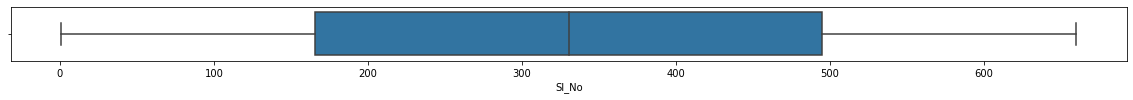

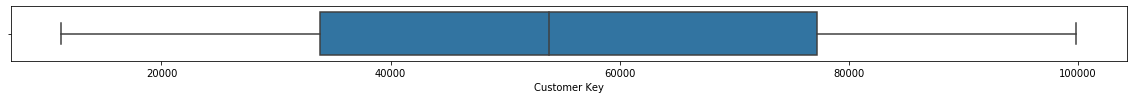

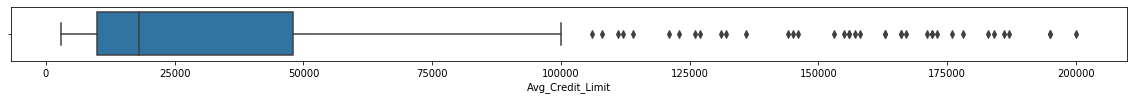

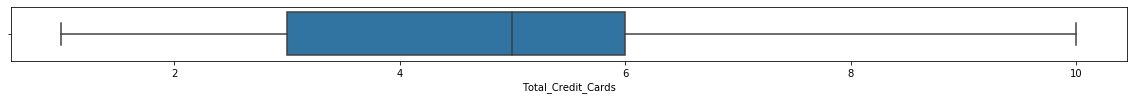

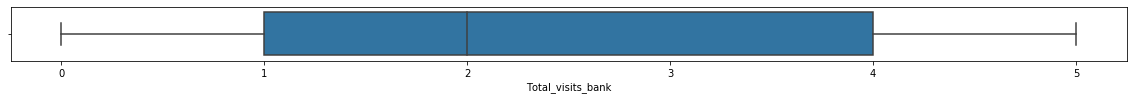

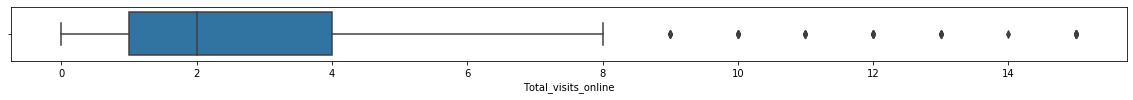

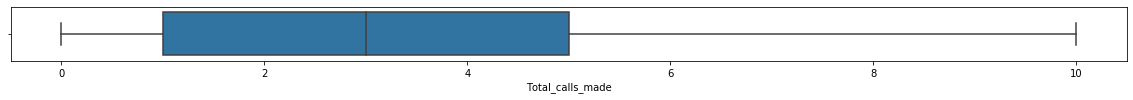

In [5]:
#Check if there is any weird value in any Continuous feature [Outlier detection and normal Plot]
print(df.columns)
for c in df.columns:
    fig, axs = plt.subplots(figsize= (20,1))
    cont_plot = sns.boxplot(x=df[c])
    plt.show()
#Outlier is highest for Avg_Credit_Limit and Total_visit_online. Skewness was also highest for these two.
#Outlier columns will be transformed later on code.

In [6]:
#Column Sl_No and Customer Key are NOT needed as this is just counting of rows
df = df.drop(['Sl_No','Customer Key'],axis=1)
#Dropping not needed columns

In [7]:
#Drops Any duplicated rows AFTER drops
df.drop_duplicates(subset = None, keep = 'first', inplace=True)
df.shape
#After removing two columns, 11 duplicate rows were found and were dropped.

(649, 5)

(array([-4., -2.,  0.,  2.,  4.,  6.,  8., 10., 12., 14.]),
 <a list of 10 Text xticklabel objects>)

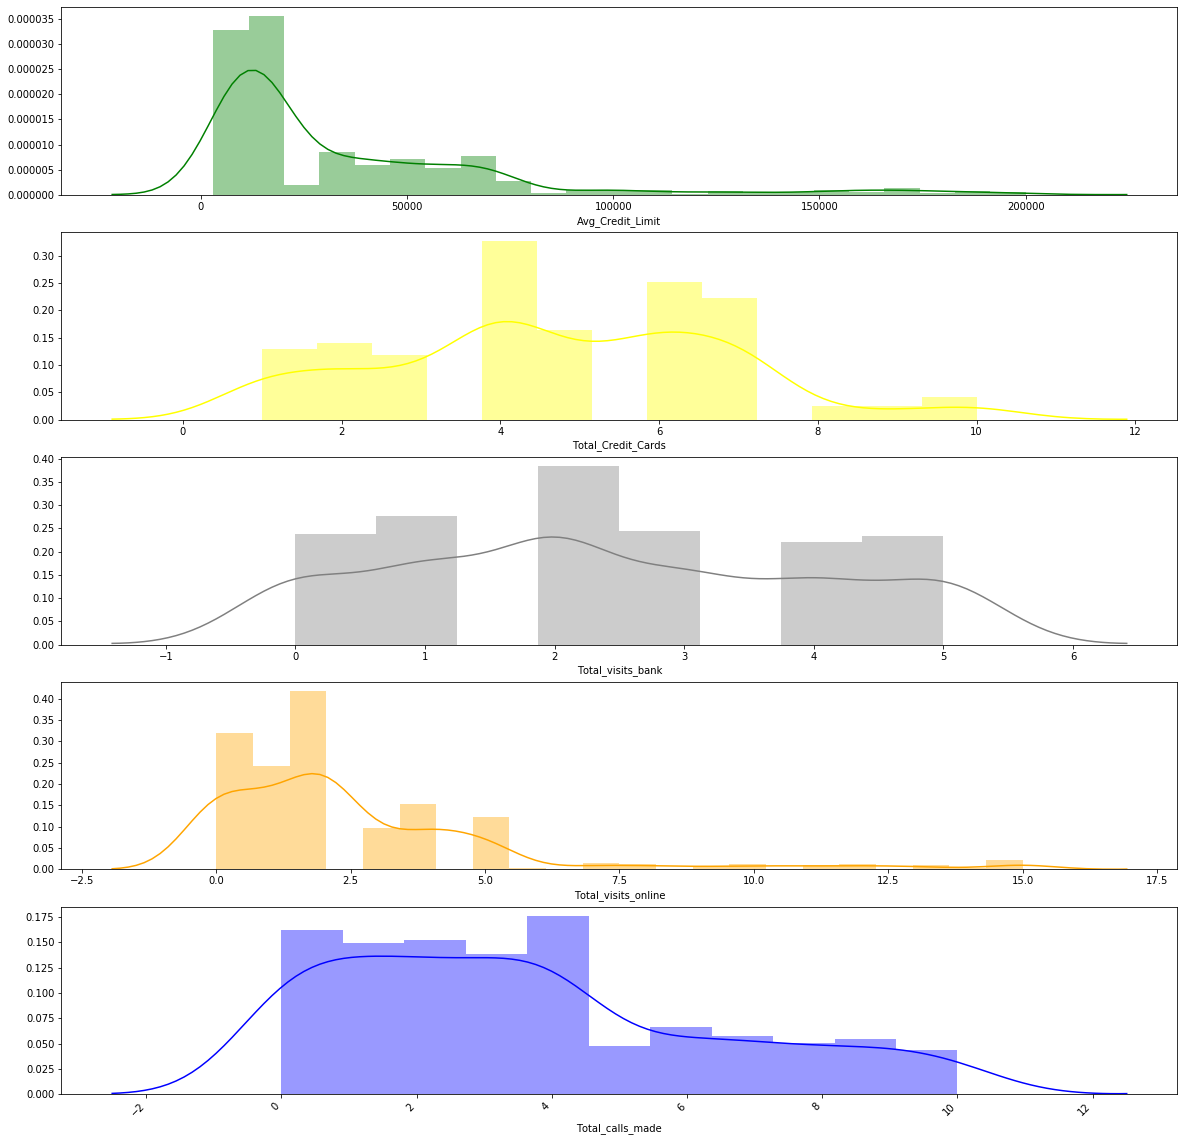

In [8]:
#Check Histogram to approximately determine No. of Clusters
fig, axs = plt.subplots(figsize= (20,20),nrows = 5)
Avg_Credit_Limit = sns.distplot(df['Avg_Credit_Limit'],color='green',ax=axs[0]) 
Total_Credit_Cards = sns.distplot(df['Total_Credit_Cards'],color='yellow',ax=axs[1]) 
Total_visits_bank = sns.distplot(df['Total_visits_bank'],color='grey',ax=axs[2]) 
Total_visits_online = sns.distplot(df['Total_visits_online'],color='orange',ax=axs[3]) 
total_calls_made = sns.distplot(df['Total_calls_made'],color='blue',ax=axs[4]) 
plt.xticks(rotation=45,horizontalalignment='right', fontweight='light')   #x-Axis label change

#From looking at Total_Credit_Cards and Total_visits_bank, Cluster of three for four needed can be expected

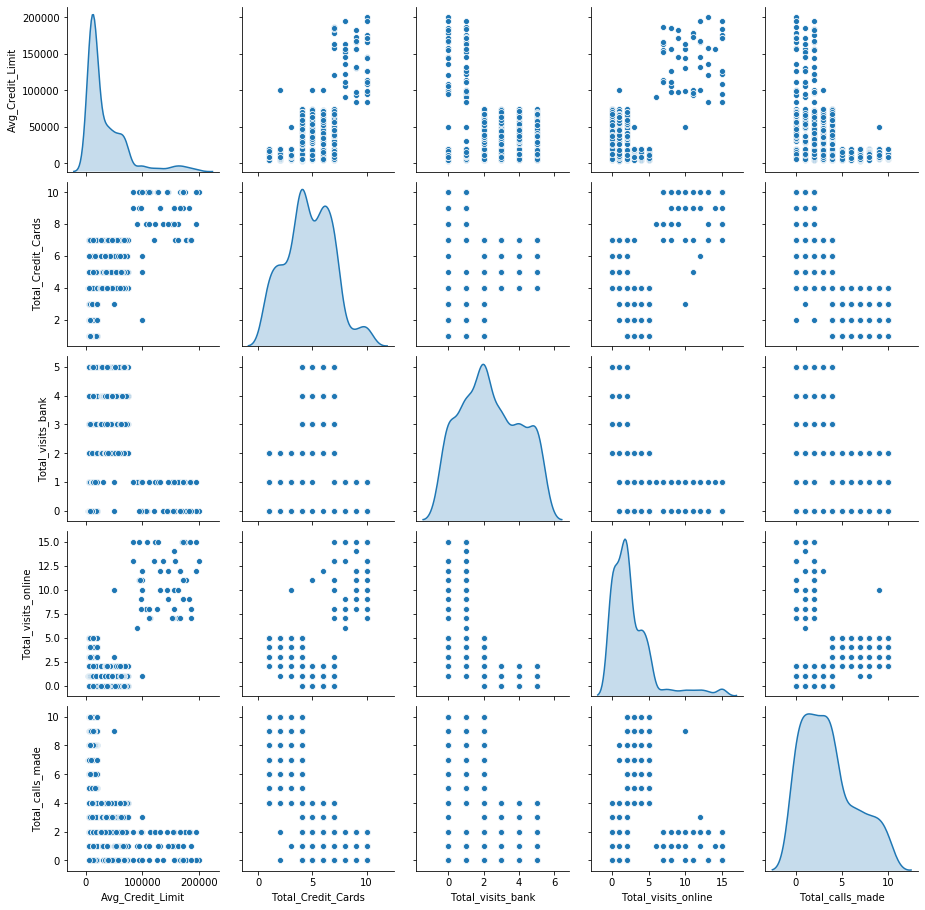

In [9]:
#Bivariate to check for any correlation WITHOUT normalizing data
#Below charts will still look the same even WITH normalized data
sns.pairplot(df, diag_kind = 'kde')

#Total_Credit_Cards vs Avg_Credit_Limit shows positive correlation
#Avg_Credit_Limit vs Total visits online shows positive correlation
#Total_Credit_Cards vs Total visits online shows positive correlation

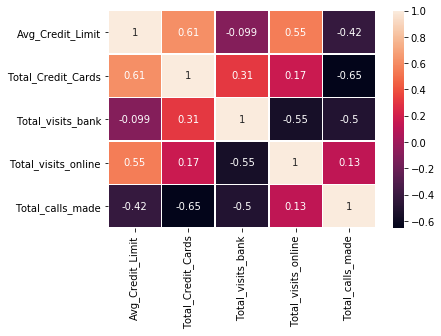

In [10]:
corr = df.corr()
ax = sns.heatmap(corr, linewidths=.5,annot=True)
#Please refer to below for correlation. anything above 0.5 and below -0.5 is considered somewhat correlated. Rest are not really correlated.

In [11]:
#Filter onnly ones that are highly correlated.
highest_corr = corr[(corr>0.4)|(corr<-0.4)]
highest_corr
#Even though few features are highly correlated with one another, I will NOT drop any features when performing Unsupervised learning because I do not see correlations as high enough to remove features

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Avg_Credit_Limit,1.000000,0.612623,NaN,0.552941,-0.418351
Total_Credit_Cards,0.612623,1.000000,NaN,NaN,-0.653325
Total_visits_bank,NaN,NaN,1.000000,-0.554078,-0.504256
Total_visits_online,0.552941,NaN,-0.554078,1.000000,NaN
Total_calls_made,-0.418351,-0.653325,-0.504256,NaN,1.000000


In [12]:
#Normalize Data
scaled_df=df.apply(zscore)
#This scales down mean to 0 and increase and decrease by std value

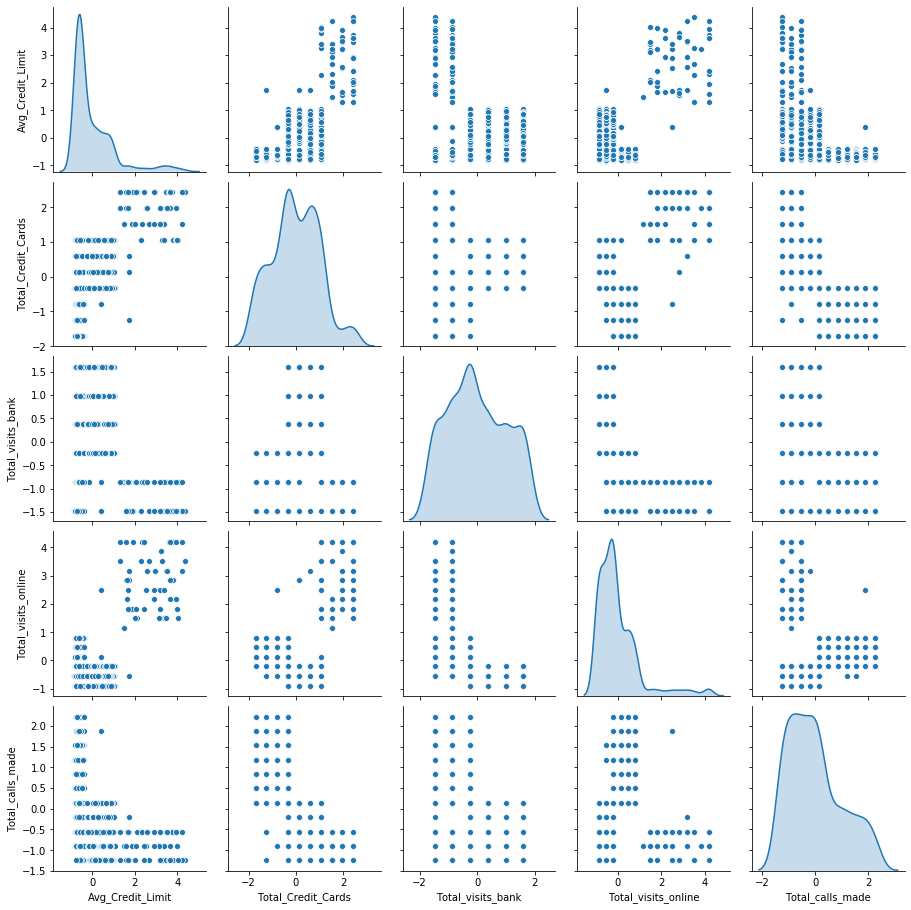

In [13]:
sns.pairplot(scaled_df, diag_kind = 'kde')
#Same as without scaling. 4 clusters can be assumed.

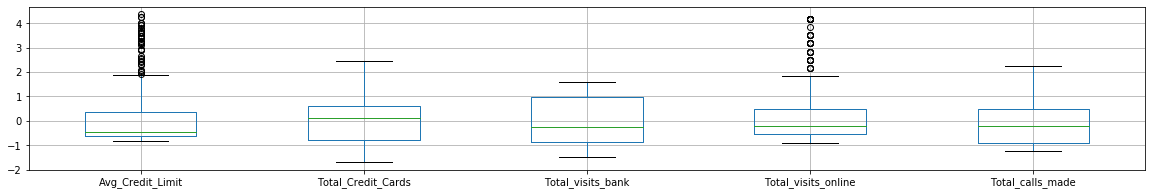

In [14]:
#Putting all in ONE box plot as normalized data would have similar Y-Axis
scaled_df.boxplot(figsize=(20,3))
#Shows outliers on Avg_Credit_Limit and Total_visits_online

In [15]:
#Need to Remove Outliers by either:
# 1) Removing
# 2) Tranforming

In [16]:
#Will approach with removing outliers by checking if there are many outliers to remove
print(scaled_df[scaled_df['Avg_Credit_Limit']>2].count())
print(scaled_df[scaled_df['Total_visits_online']>2].count())

pd.crosstab(scaled_df['Avg_Credit_Limit']>2, scaled_df['Total_visits_online']>2)

#There are Total of 26 rows where BOTH Avg_Credit_Limit and Total_visits_online are higher than 2. Rest of other 11 are either one feature is higher than 2. via.
#Since 26 rows are must removal, and removing other 11 rows will not hurt my overall data, as I am only removing 5% of dataset!

Avg_Credit_Limit       37
Total_Credit_Cards     37
Total_visits_bank      37
Total_visits_online    37
Total_calls_made       37
dtype: int64
Avg_Credit_Limit       37
Total_Credit_Cards     37
Total_visits_bank      37
Total_visits_online    37
Total_calls_made       37
dtype: int64


Total_visits_online,False,True
Avg_Credit_Limit,,
False,601,11
True,11,26


In [17]:
scaled_df_filter = scaled_df.loc[(scaled_df['Avg_Credit_Limit']<2.001)]
scaled_df_filter = scaled_df_filter.loc[(scaled_df_filter['Total_visits_online']<2.001)]
scaled_df_filter.shape
#Removed exactly 37 rows ending up from 649 (after removing duplicates) to 601 (after filtering outliers)

(601, 5)

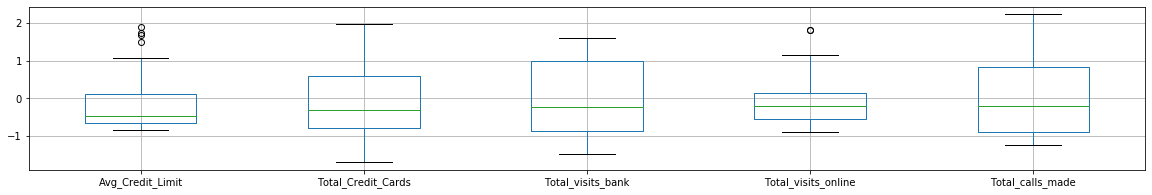

In [18]:
#Putting all in ONE box plot as normalized data would have similar Y-Axis
scaled_df_filter.boxplot(figsize=(20,3))
#looks much better with only minimal outliers out of 600 rows of data. Ready for Clustering.

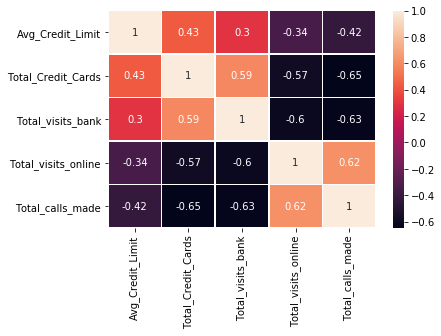

In [19]:
#Correlation is still similar even after filtering
corr_filtered = scaled_df_filter.corr()
ax = sns.heatmap(corr_filtered, linewidths=.5,annot=True)

#Please refer to below for correlation. anything above 0.5 and below -0.5 is considered somewhat correlated. Rest are not really correlated.

In [20]:
#Check Skewness and other statistical details on Continuous Variable to check for outlier spread after filter.
df_stat_filter = pd.concat([scaled_df_filter.describe().T,scaled_df_filter.skew()],axis=1).rename(columns = {0:'Skewness'})
df_stat_filter['Range']=df_stat_filter['max']-df_stat_filter['min']
df_stat_filter
#Skewness has dropped significantly

,count,mean,std,min,25%,50%,75%,max,Skewness,Range
Avg_Credit_Limit,601.0,-0.226031,0.564527,-0.843684,-0.658424,-0.473163,0.109085,1.882294,1.094540,2.725979
Total_Credit_Cards,601.0,-0.144764,0.870999,-1.707474,-0.786701,-0.326314,0.594459,1.975619,-0.238668,3.683092
Total_visits_bank,601.0,0.088202,0.984403,-1.476410,-0.860606,-0.244803,0.986803,1.602607,0.038714,3.079016
Total_visits_online,601.0,-0.229539,0.546182,-0.889320,-0.550407,-0.211494,0.127419,1.821983,0.621269,2.711302
Total_calls_made,601.0,0.065571,1.001792,-1.248443,-0.900701,-0.205216,0.838011,2.228980,0.571522,3.477423


## 2) Comments on Code

Please look above outputs for comments. Summary is that we need 3-4 clusters while some features showing positive correlation with two columns having outliers that causes the skewness. Outliers and duplicated values were removed based on analysis

## 3-7) 
## Execute K-means clustering use elbow plot and analyse clusters using boxplot
## Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot
## Calculate average silhouette score for both methods.
## Compare K-means clusters with Hierarchical clusters.
## Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions.

In [21]:
#Import Needed packages for K-mean models
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

In [22]:
df_final = scaled_df_filter.copy().reset_index(drop=True)
#Create copy of filtered data as final data so it can be used in model without impacting filtered data

silhouette score for 2 cluster: 0.5048098844404215
silhouette score for 3 cluster: 0.3382398011223366
silhouette score for 4 cluster: 0.24588095344678274
silhouette score for 5 cluster: 0.23207103604428855
silhouette score for 6 cluster: 0.22280498291412865
silhouette score for 7 cluster: 0.21282226475932037
silhouette score for 8 cluster: 0.22241365572939442
silhouette score for 9 cluster: 0.2059469313686426
silhouette score for 10 cluster: 0.20820351731559902


Text(0.5, 1.0, 'Elbow Method given k')

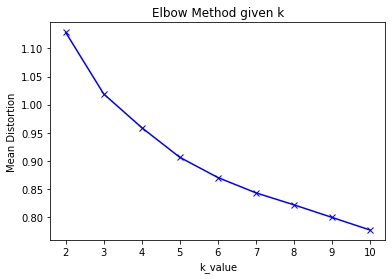

In [23]:
#K-MEAN CLUSTER with silhouette score w/ boxplot comparison with s-coefficient comparison

#Going to run k=2 to k=10
k_value=range(2, 11)
meanDistortions=[] #append mean distortion after getting min avg euclidean distance

for k in k_value:
    kmeans=KMeans(n_clusters=k)
    kmeans.fit(df_final) #Fit kmean model with given k
    prediction=kmeans.predict(df_final) #Get assigned cluster
    silhouette_avg = silhouette_score(df_final, prediction)
    print(f"silhouette score for {k} cluster: {silhouette_avg}")

    meanDistortions.append(sum(np.min(cdist(df_final, kmeans.cluster_centers_, 'euclidean'), axis=1)) / df_final
                           .shape[0]) #getting mean distortion
    
plt.plot(k_value, meanDistortions, 'bx-')
plt.xlabel('k_value')
plt.ylabel('Mean Distortion')
plt.title('Elbow Method given k')

#Elbow is not emerging from given k values
#Above distplot shows that k should be around 3 to 4 but we also may have to look at higher k such as 5. 
# Silhouette score is highest with 2 clusters while lowest at k = 8 and k=10. However, I will only look up to only k=5.

In [24]:
#Set the value of k=2
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_final)
#Append 'labels' column to df_train so we can take the average grouping by labels and plot on boxplot to see diffeence between each group
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')
df_labeled = df_final.join(df_labels)
df_grouped = df_labeled.groupby(by='labels').agg('mean')
df_grouped

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,-0.603688,-1.058747,-0.891397,0.307659,1.144656
1,-0.007962,0.382995,0.653849,-0.539732,-0.557522


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A052E3DE48>,
      dtype=object)

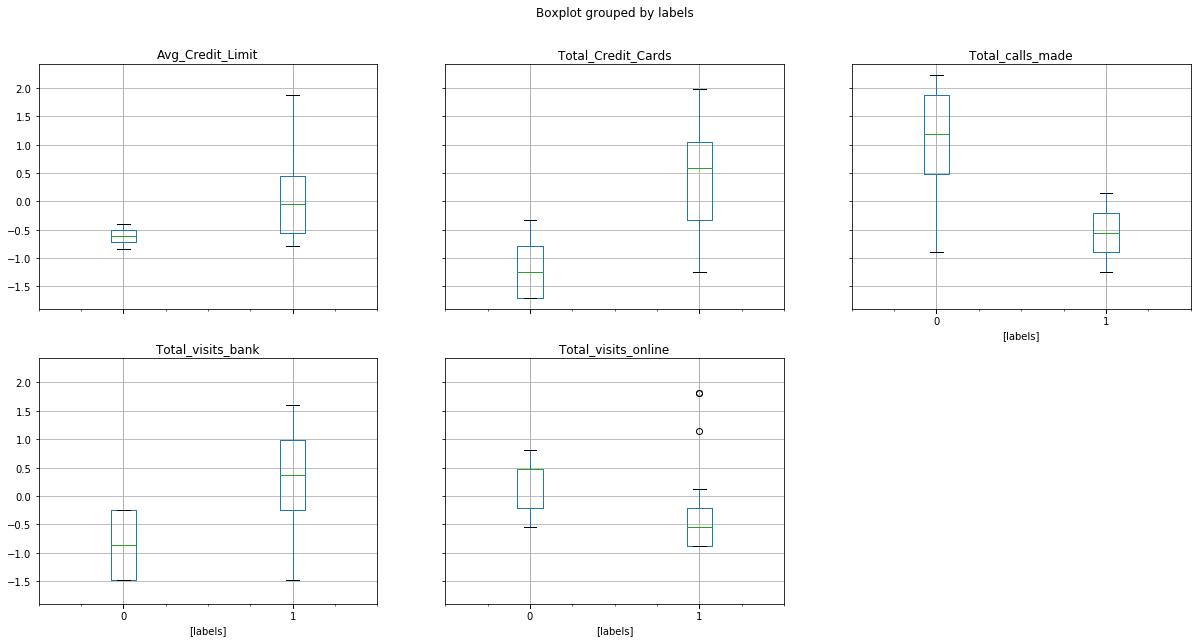

In [25]:
df_labeled.boxplot(by='labels', layout = (2,3), figsize = (20,10))
#Group 0 shows lowest Total_Credit_Limit, Lowest Total_Credit_Cards, Lowest Total_visits_bank, highest Total_Visits_online, highest total_calls_made
#Group 1 is via from Group 0
# k=2 shows good distinguish between groups

In [26]:
#Set the value of k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_final)
#Append 'labels' column to df_train so we can take the average grouping by labels and plot on boxplot to see diffeence between each group
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')
df_labeled = df_final.join(df_labels)
df_grouped = df_labeled.groupby(by='labels').agg('mean')
df_grouped

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,0.050833,0.395498,0.030606,-0.526564,-0.537231
1,-0.603907,-1.066751,-0.894660,0.314836,1.163318
2,-0.080611,0.355556,1.303027,-0.548575,-0.573635


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A05483AB08>,
      dtype=object)

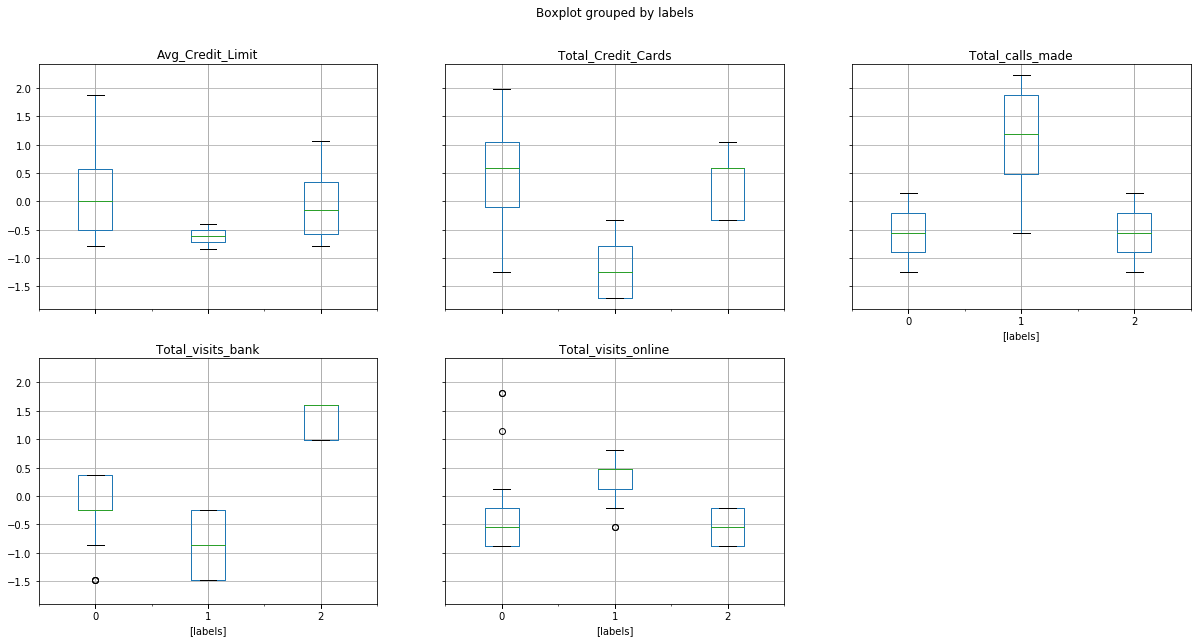

In [27]:
df_labeled.boxplot(by='labels', layout = (2,3), figsize = (20,10))
#Group 0 shows highest Total_Credit_Limit, highest Total_Credit_Cards
#Group 1 shows lowest AVG_CREDIT_LIMIT, lowest Total_Credit_Cards, and lowest Total_visits_bank, highest Total_visits_online, highest Total_calls_made
#Group 2 shows highest Total_visits_bank, lowest Total_visits_online, lowest Total_calls_made
# k=3 shows good distinguish between groups

In [28]:
#repeat above process with k=4
#Set the value of k=4
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_final)
#Append 'labels' column to df_train so we can take the average grouping by labels and plot on boxplot to see diffeence between each group
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')
df_labeled = df_final.join(df_labels)
df_grouped = df_labeled.groupby(by='labels').agg('mean')
df_grouped

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,-0.602284,-1.019219,-0.848166,0.291740,0.497293
1,-0.080611,0.355556,1.303027,-0.548575,-0.573635
2,-0.604836,-1.091088,-0.926767,0.320683,1.674316
3,0.060609,0.408895,0.041106,-0.531386,-0.542313


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A054517308>,
      dtype=object)

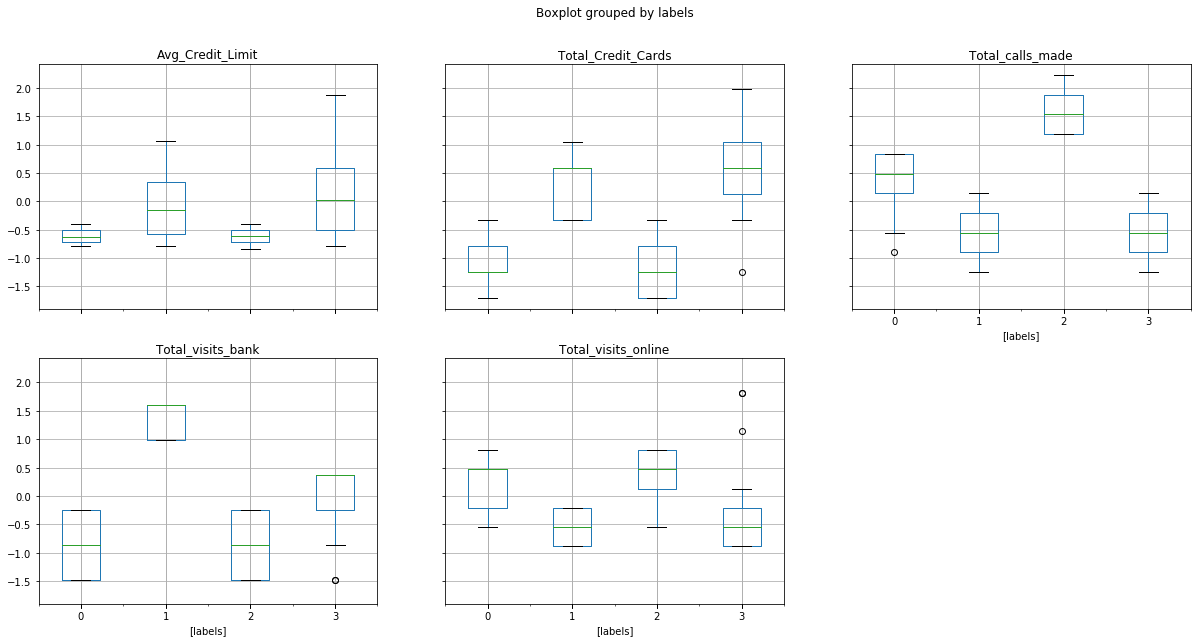

In [29]:
df_labeled.boxplot(by='labels', layout = (2,3), figsize = (20,10))
#SAME COMMENT AS PREVIOUS TWO BY ANALYZING MAX AND MIN VALUES FOR EVERY GROUP
#Bar charts shows Groups are well distinguished

In [30]:
#repeat above process with k=5
#Set the value of k=5
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_final)
#Append 'labels' column to df_train so we can take the average grouping by labels and plot on boxplot to see diffeence between each group
df_labels = pd.DataFrame(kmeans.labels_ , columns = list(['labels']))
df_labels['labels'] = df_labels['labels'].astype('category')
df_labeled = df_final.join(df_labels)
df_grouped = df_labeled.groupby(by='labels').agg('mean')
df_grouped

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
labels,,,,,
0,0.731949,0.434919,0.175894,-0.523562,-0.552958
1,-0.603823,-1.151692,-0.910536,0.335041,1.718331
2,-0.406179,0.394822,0.071273,-0.556405,-0.552958
3,-0.603550,-0.964097,-0.871906,0.279774,0.560455
4,-0.186001,0.343590,1.337111,-0.538230,-0.563370


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A054F47188>,
      dtype=object)

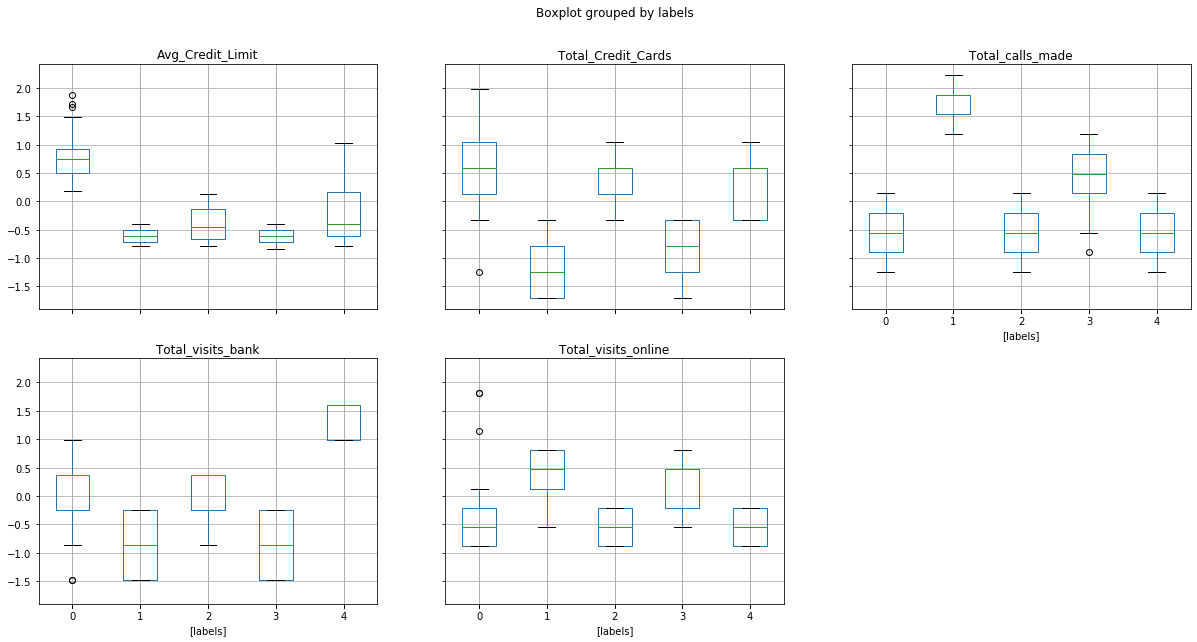

In [31]:
df_labeled.boxplot(by='labels', layout = (2,3), figsize = (20,10))
#SAME COMMENT AS PREVIOUS TWO BY ANALYZING MAX AND MIN VALUES FOR EVERY GROUP
#Bar charts shows Groups are well distinguished

For n_clusters = 2 The average silhouette_score is : 0.5048098844404215
For n_clusters = 3 The average silhouette_score is : 0.3382398011223366
For n_clusters = 4 The average silhouette_score is : 0.24666446464224676
For n_clusters = 5 The average silhouette_score is : 0.23170037752895437


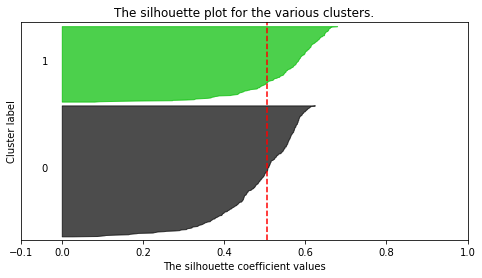

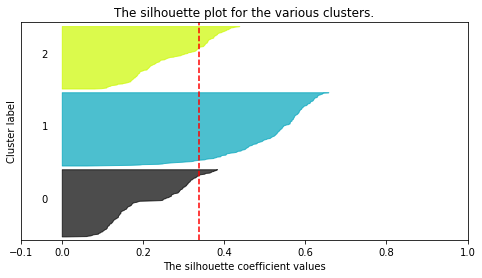

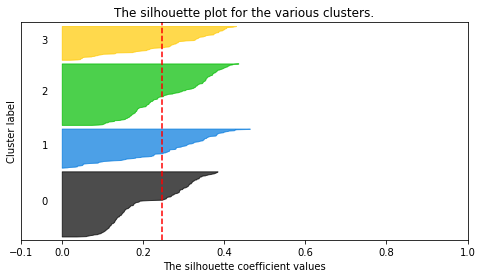

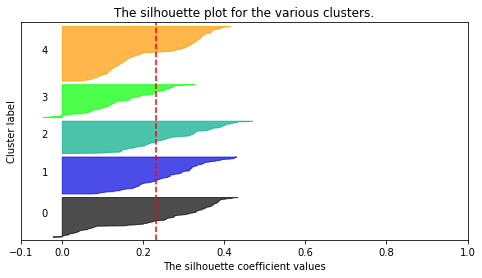

In [32]:
#Code used from one of python script given by mentor
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_final) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df_final)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_final, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_final, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    
plt.show()


#As shown below, Cluster of 3 or 4 suffice as k=5 gives negative coefficient
#Red dash line is AVG silhouette score
#K=2 shows the best but will use k=4 to test out below Agg cluster.

single linkage
         Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
labels                                                            
0              -0.238872           -0.152030           0.096622   
1               1.776431            1.745425          -1.476410   
2               1.723499           -1.247087          -0.860606   
3               1.485307            1.515232          -0.860606   

        Total_visits_online  Total_calls_made  
labels                                         
0                 -0.238176          0.072046  
1                  1.821983         -0.726830  
2                 -0.550407         -1.248443  
3                  1.144157         -0.900701   
-----------------------------------------------------------------

complete linkage
         Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
labels                                                            
0              -0.600921           -1.056654          -0.894196   
1     

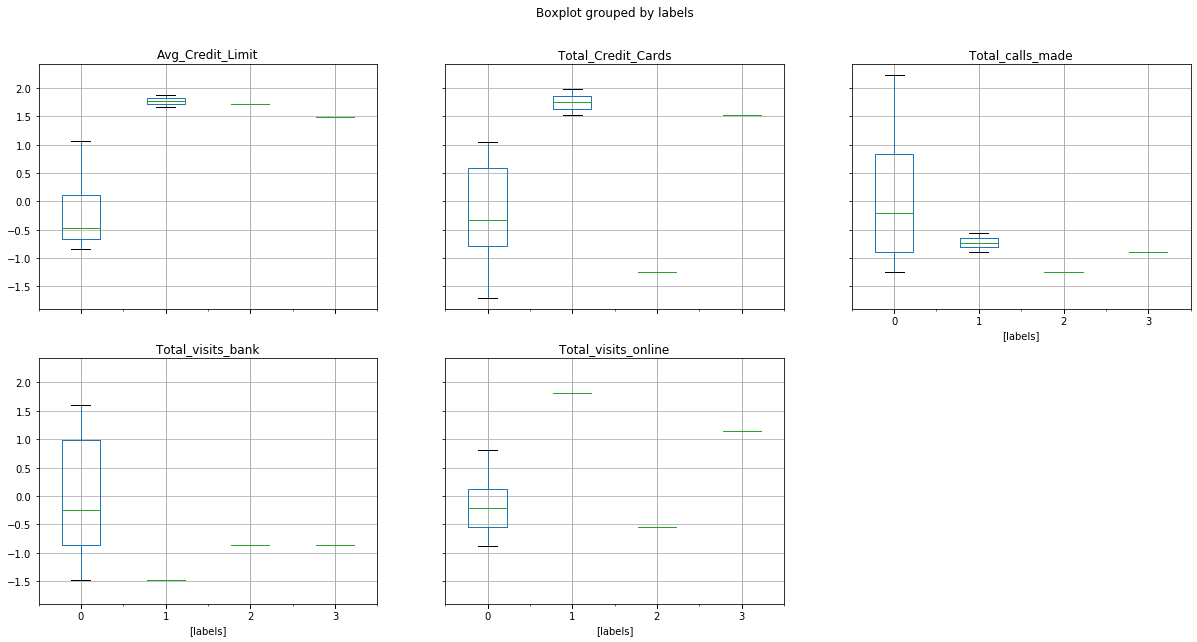

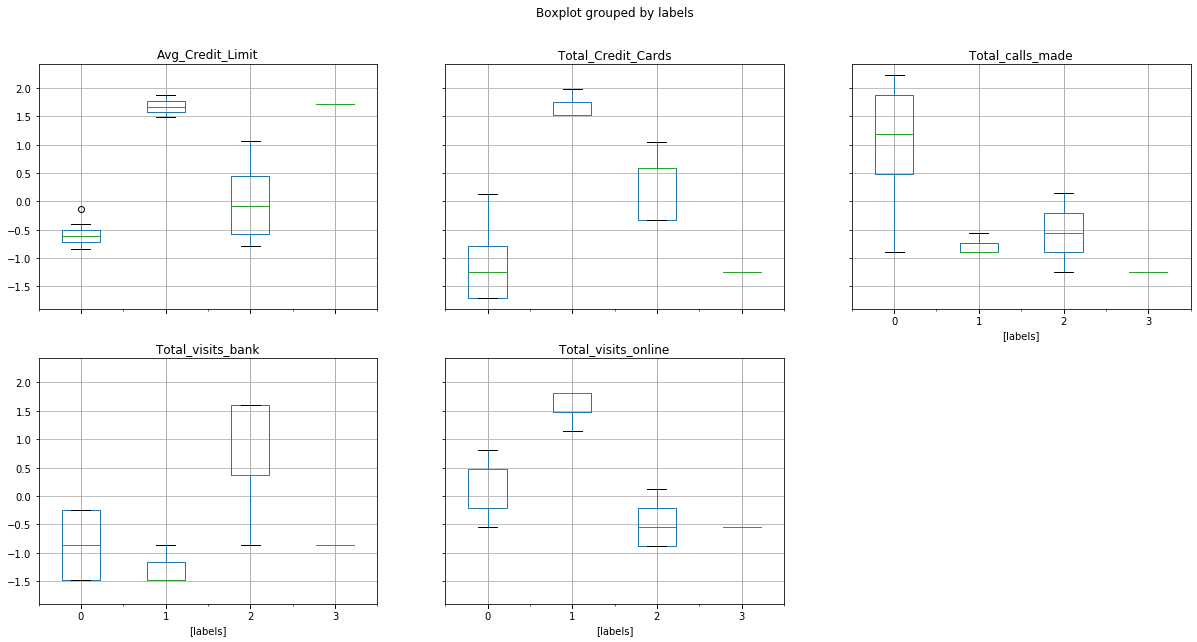

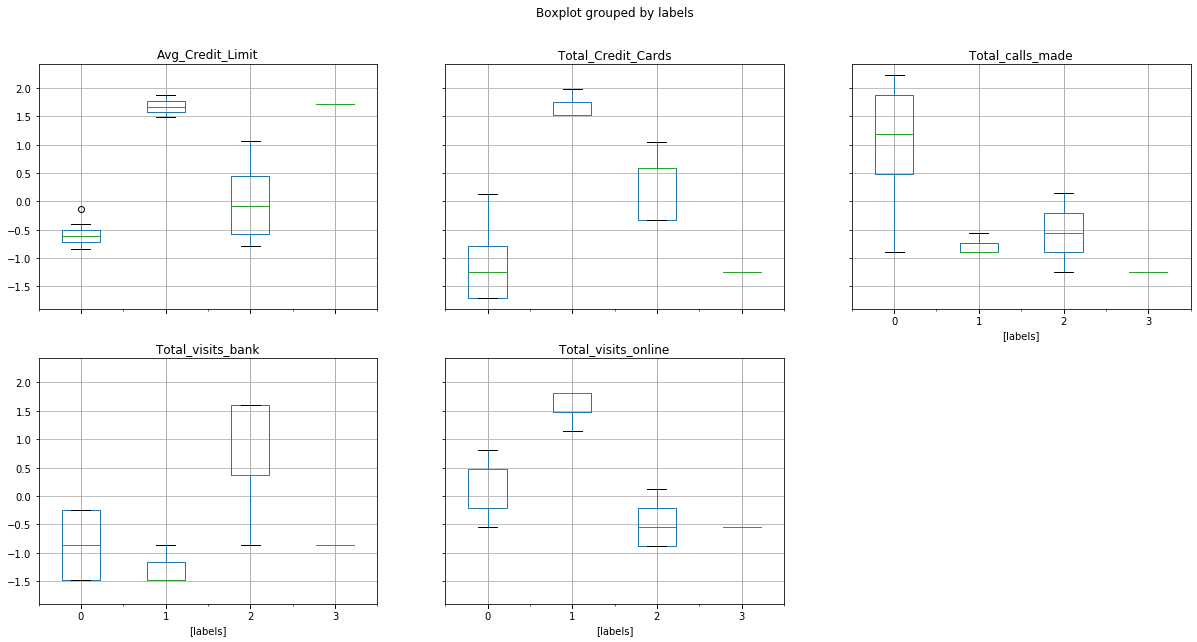

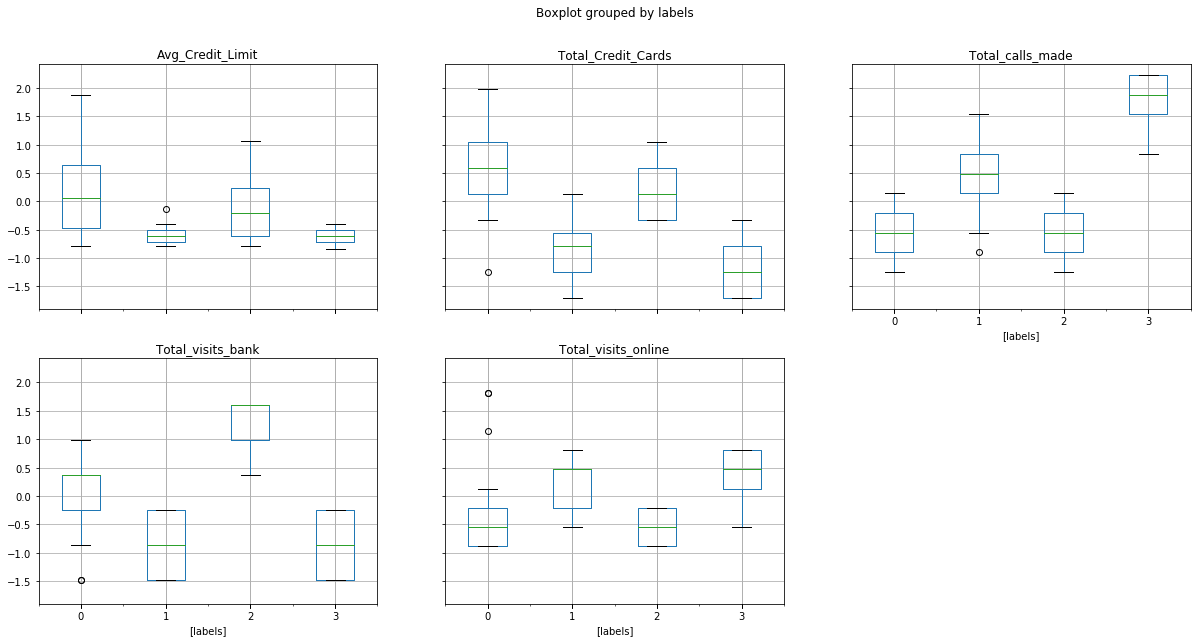

In [33]:
#K Value will be 4 from K-Mean analysis above


#Check Agglomerative Clustering and Analyse clusters formed using boxplot
from sklearn.cluster import AgglomerativeClustering
link = ['single','complete','average','ward']
for l in link:
    df_h_cluster = df_final
    h_cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage=l)
    h_cluster.fit(df_h_cluster)
    df_h_cluster['labels'] = h_cluster.labels_
    df_Clust = df_h_cluster.groupby(['labels'])
    print(l,'linkage\n',df_Clust.mean(),'\n-----------------------------------------------------------------\n')    
    df_h_cluster.boxplot(by='labels', layout = (2,3), figsize = (20,10))

#Boxplots are respectively to linkage list    
    

#Single Linkage:
#Label 0 has highest Total_Credit_Cards, lowest Total_visits_bank, highest Total_visits_online
#Label 1 has highest Total_visits_bank
#Label 2 has highest Avg_Credit_Limit, lowest Total_Credit_cards, lowest Total_visits_online, lowest Total_calls_made
#Label 3 has lowest Avg_Credit_Limit, highest Total_calls_made


#Complete Linkage:
#Label 0 has no min or max of all features but are all in between
#Label 1 has highest Total_visits_bank, lowest Total_visit_online
#Label 2 has highest Avg_Credit_Limit, highest Total_Credit_cards, lowest Total_visits_bank, highest Total_visits_online, lowest Total_calls_made
#Label 3 has lowest Avg_Credit_Limit, lowest Total_Credit_Cards, highest Total_calls_made


#Average Linkage:
#Label 0 has highest Total_visits_bank
#Label 1 has highest Total_Credit_Cards, lowest Total_visit_bank, highest Total_visits_online
#Label 2 has lowest Avg_Credit_Limit, highest Total_calls_made
#Label 3 has highest Avg_Credit_Limit, lowest Total_Credit_Cards, lowest Total_visits_online, lowest Total_calls_made


#Ward Linkage:
#Label 0 has highest Avg_Credit_Limit, highest Total_Credit_Cards
#Label 1 has highest Total_visit_bank, lowest Total_visits_online, lowest Total_calls_made
#Label 2 has lowest Avg_Credit_Limit
#Label 3 has lowest Total_Credit_Cards, lowest Total_visits_bank, highest Total_calls_made



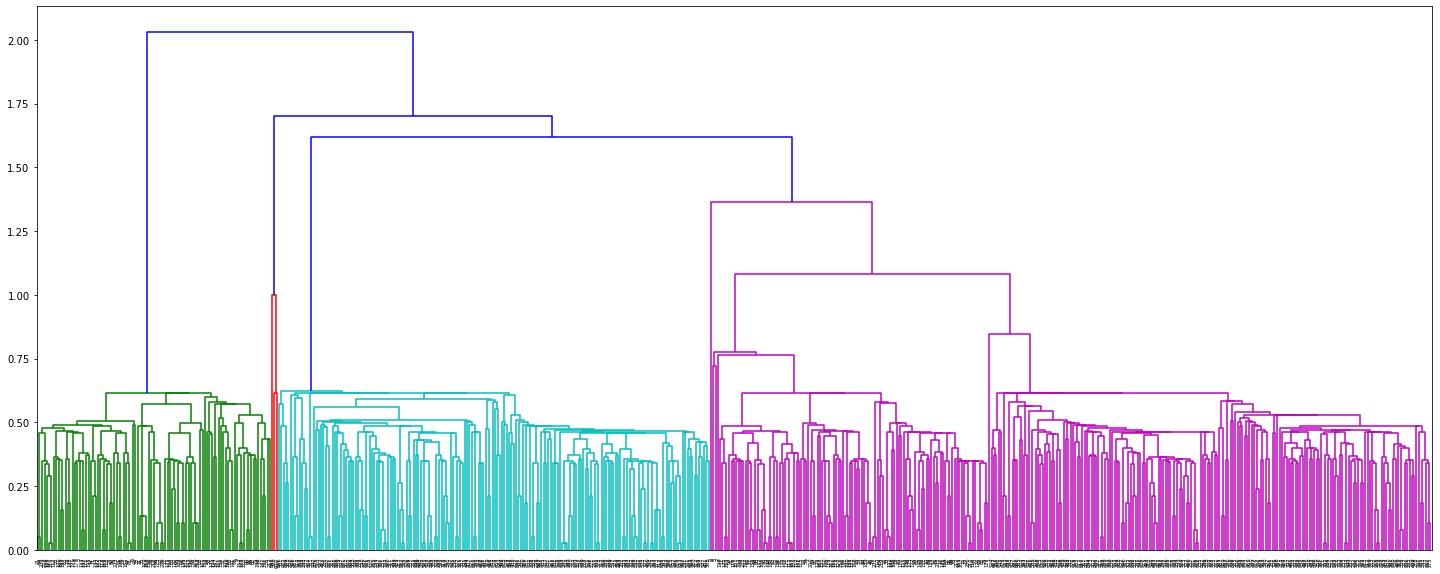

Cophenetic Coefficient for  single  is:  0.8135736913653058 




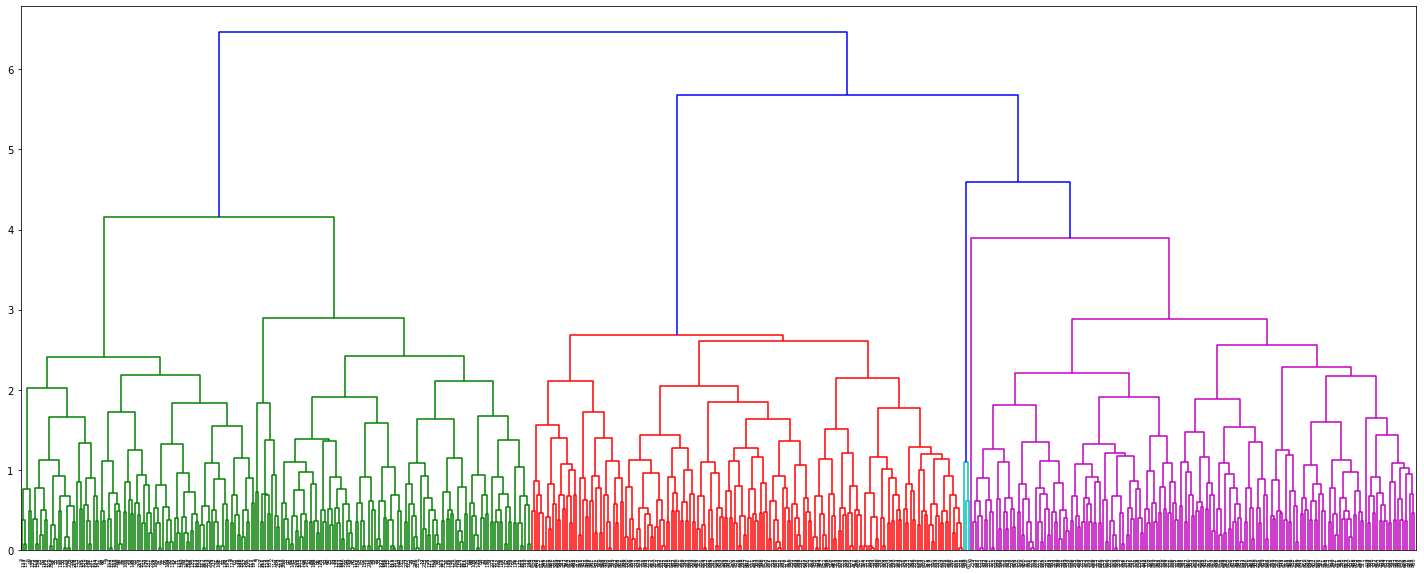

Cophenetic Coefficient for  complete  is:  0.8121044229867047 




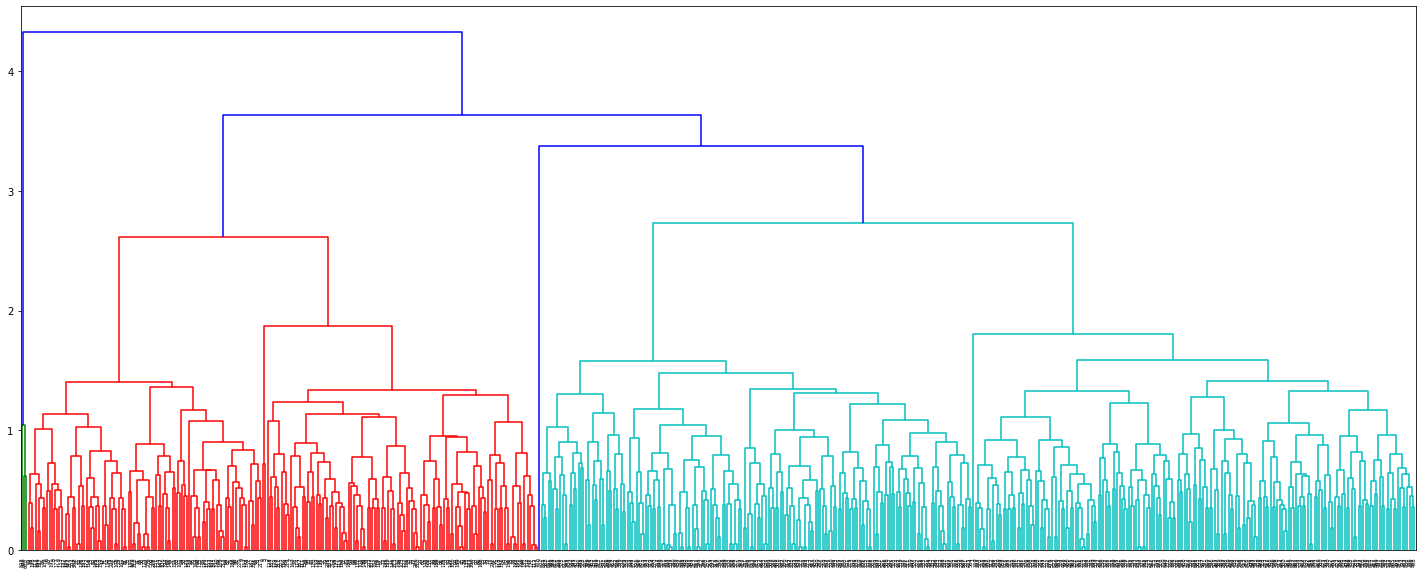

Cophenetic Coefficient for  average  is:  0.8375344035319842 




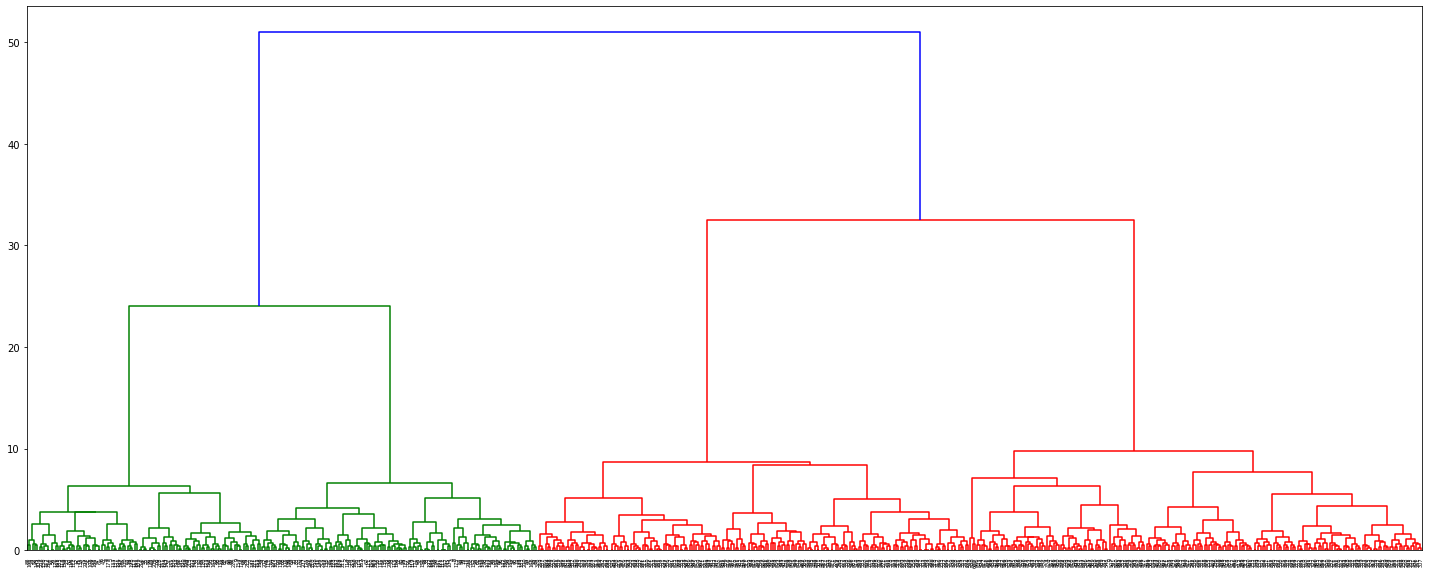

Cophenetic Coefficient for  ward  is:  0.818656132732666 




In [34]:
#Hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coefficient
link = ['single','complete','average','ward']
from scipy.cluster.hierarchy import cophenet,dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
for li in link:
    Z = linkage(df_h_cluster, li , metric='euclidean')
    c, coph_dists = cophenet(Z , pdist(df_h_cluster))
    plt.figure(figsize=(25, 10))
    dendrogram(Z)
    plt.show()
    
    print('Cophenetic Coefficient for ',li,' is: ',c,'\n\n')
    #Dendrograms are respectively to link list    

#Cophenetic Coefficient is HIGHEST with Average Linkage, which shows the best clustering. Closer to 1 is better.
#Single shows max distance of 1 will give sufficient k value
#Complete shows max distance of 3 will give sufficient k value
#Average shows max distance of 2.5 will give sufficient k value
#Ward shows max distance of 10 will give sufficient k value
#These numbers can be used to calculate silhouette scores
#When K = 4, Visual wise, WARD shows well separated clusters with max distance of 13 to cut the dendros. 
#However, other linkages other than WARD shows one group with VERY FEW sample indexes

In [35]:
#Silhouette scores calculation k = 4 or greater
link_maxd={'single':1,'complete':3,'average':2.5,'ward':10}
for k,v in link_maxd.items():
    Z = linkage(df_h_cluster, k , metric='euclidean')
    clusters = fcluster(Z, v, criterion='distance')
    sil_score = silhouette_score(df_h_cluster,clusters)
    print('Silhouette Score of',k,'is:',sil_score,'\n')
    
#None of Silhouette scores are closer to 1. Average Silhouette score was highest with 0.48. 

Silhouette Score of single is: 0.47793608814793753 

Silhouette Score of complete is: 0.47793608814793753 

Silhouette Score of average is: 0.47793608814793753 

Silhouette Score of ward is: 0.4871086530786786 



In [36]:
#Silhouette scores calculation with k=2 clustering
link_maxd={'single':1.5,'complete':6,'average':4,'ward':50}
for k,v in link_maxd.items():
    Z = linkage(df_h_cluster, k , metric='euclidean')
    clusters = fcluster(Z, v, criterion='distance')
    sil_score = silhouette_score(df_h_cluster,clusters)
    print('Silhouette Score of',k,'is:',sil_score,'\n')
    
#None of Silhouette scores are closer to 1 with k=2. COMPLETE and WARD Linkage Silhouette score was highest with 0.55 with k=2. 

Silhouette Score of single is: 0.4009336257922919 

Silhouette Score of complete is: 0.43197689467006317 

Silhouette Score of average is: 0.34375832127973704 

Silhouette Score of ward is: 0.43197689467006317 



In [37]:
#Comparing both K-Mean and Hierarchical:
#When K = 2:
#k-Mean Sil-Score = 0.5 and Hierarchical Sil-Score = 0.55 using COMPLETE and WARD linkage. Hierarchical performed better.

#When K = 4 or higher:
#k-Mean Sil-Score were below 0.35 starting 0.33 with k = 4. Hierarchical Sil-score with k=4 or above, min Sil-score was 0.3 using WARD Linkage while Sil-score was 0.47 using AVERAGE Linkage.
# For Hierarchical, using AVERAGE Linkage performed the best with 0.47 when k = 4 than k-Mean with 0.35.

#Overall, Hierarchical with Average linkage with k = 4 was chosen as best model. k=2 is the best performer but grouping 2 is too generalized. However, k=2 still can be used if needed.
